## SETUP

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from utils.utils import open_4_channel
from utils.resnet import Resnet4Channel

In [3]:
path = Config.data_path()/'proteinatlas'

In [4]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ', classes=[str(i) for i in range(28)])) # 27 classes

In [5]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [6]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [7]:
src.add_test(test_fnames, label='0');
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [8]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [9]:
# get_transforms returns tfms for train & valid: https://docs.fast.ai/vision.transform.html#get_transforms
train_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                            max_lighting=0.05, max_warp=0.)
size = 128

In [10]:
data = (src.transform((train_tfms, _), size=size)
        .databunch().normalize(protein_stats))

In [11]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6], m[1])

In [12]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [13]:
learn = create_cnn(
    data, 
    resnet50, 
    cut=-2, 
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path, 
    metrics=[f1_score]
)

`# learn.fit_one_cycle(15, slice(3e-5, lr/5))`

Total time: 32:32

epoch	|train_loss|	valid_loss|	fbeta
-|-|-|-
1|	0.122032	|0.119484|	0.573136
2	|0.124276|	0.121466|	0.561945
3	|0.125240|	0.124952|	0.542730
4	|0.123585|	0.125676|	0.552006
5	|0.121753|	0.120939|	0.580173
6	|0.119882|	0.117670|	0.582705
7	|0.116195|	0.112468|	0.607217
8	|0.113114|	0.110549|	0.609188
9	|0.107278|	0.110086|	0.616795
10	|0.106212|	0.109549|	0.629468
11	|0.101763|	0.103942|	0.634795
12	|0.097465|	0.101456|	0.644239
13	|0.097104|	0.100028|	0.645712
14	|0.093200|	0.099546|	0.648440
15	|0.093603|	0.099280|	0.650713


## TRAINING

left off with train/val/fbeta of: `0.093603	  0.099280	0.650713`

In [14]:
learn.load('stage-2-rn50-datablocks-sz128');

bs = 48 @ sz = 256: 

- Frozen: `6967MiB /  7611MiB` P4 GPU. 91.5% utilz.

- Unfrozen: `7549MiB /  7611MiB`

Frozen → Unfrozen **8.35%** Memory Use Increase. `(7549/7611) / (6967/7611)` = `1.0835..`

`(frac_new) / (frac_old) = frac_of_old`

In [15]:
# resize input data to 256x256; lower batch size to 48
bs   = 48; size = 256
data = (src.transform((train_tfms, _), size=size)
        .databunch(bs=bs).normalize(protein_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


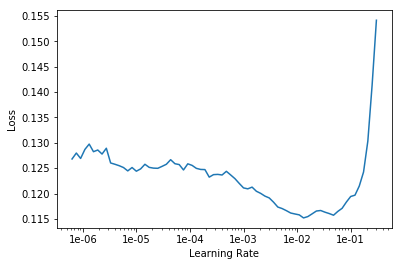

In [16]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,fbeta


In [ ]:
learn.recorder.plot_losses()

In [ ]:
3

## submissions

In [26]:
learn.save(f'stage-2-rn50-datablocks-sz{size}')

In [27]:
preds,_ = learn.get_preds(DatasetType.Test)
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]

In [29]:
import datetime; date = str(datetime.date.today()).replace('-','')

In [31]:
(path/'submissions').mkdir(exist_ok=True)

subm_msg = f"RN50 Datablocks codealong; fastai {__version__}; size {size}; stage-2; threshold: 20%; date: {date}"
subm_name = f"rn50-datablocks-sz{size}-stg2-th20p-fastai-{__version__}-{date}.csv"

subm_df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
subm_df.to_csv(path/'submissions'/subm_name, header=True, index=False)

In [ ]:
! kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/submissions/{subm_name} -m "{subm_msg}"

## END